## Start by reading the generated data


In [1]:
import numpy as np

# Load the data from the saved file
def load_data(filename):
    with np.load(filename) as data:
        return data['data'], data['alphas'], data['source_positions']

data, alphas, source_positions = load_data('heat_diffusion_noisy_data_100.npz')
data = data.reshape(data.shape + (1,))

## Define helper functions for plotting

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os


def plot_comparison(model, val_data, val_labels, times=[ 60, 70, 80, 90, 99], save_path='plots/comparison_plot.png'):
    dir_path = os.path.dirname(save_path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # Pick a random sample from the validation set
    sample_index = np.random.randint(0, val_data.shape[0])
    input_sample = np.expand_dims(val_data[sample_index], axis=0)  # Expand dims to match model input requirements
    predicted_output = model.predict(input_sample)  # Predict the output
    predicted_output = predicted_output.reshape(val_labels.shape[1:])  # Reshape prediction to match label dimensions
    
    actual_output = val_labels[sample_index]

    # Adjust time indices for plotting relative to validation label indices
    relative_times = [time - 60 for time in times]  # Adjust to index from 0 to 39

    # Set up the figure and axes
    fig, axes = plt.subplots(2, len(times), figsize=(20, 10))  # Two rows for actual and predicted

    for i, time in enumerate(relative_times):
        # Plot actual data
        ax_actual = axes[0, i]
        ax_actual.imshow(actual_output[time], cmap='hot', interpolation='nearest')
        ax_actual.set_title(f'Time step {times[i]}')
        ax_actual.axis('off')

        # Plot predicted data
        ax_pred = axes[1, i]
        ax_pred.imshow(predicted_output[time], cmap='hot', interpolation='nearest')
        ax_pred.axis('off')

    # Set row titles
    axes[0, 0].set_ylabel('Actual', fontsize=14)
    axes[1, 0].set_ylabel('Predicted', fontsize=14)

    # Adjust layout to prevent overlapping and ensure everything fits
    plt.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.95, hspace=0.3, wspace=0.1)
    #plt.savefig(save_path)
    plt.show()

In [29]:
import imageio.v2 as imageio
import io
from IPython.display import Image, display 

def plot_comparison_as_gifs(model, val_data, val_labels, save_dir='gifs'):
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Pick a random sample from the validation set
    sample_index = np.random.randint(0, val_data.shape[0])
    input_sample = np.expand_dims(val_data[sample_index], axis=0)  # Expand dims to match model input requirements
    predicted_output = model.predict(input_sample)  # Predict the output
    predicted_output = predicted_output.reshape(val_labels.shape[1:])  # Reshape prediction to match label dimensions

    actual_output = val_labels[sample_index]

    images = []  # List to hold all the frames for the GIF
    for time_step in range(actual_output.shape[0]):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # One row, two columns for actual and predicted

        # Display actual data
        axes[0].imshow(actual_output[time_step].squeeze(), cmap='hot', interpolation='nearest')
        axes[0].set_title('Actual Data')
        axes[0].axis('off')

        # Display predicted data
        axes[1].imshow(predicted_output[time_step].squeeze(), cmap='hot', interpolation='nearest')
        axes[1].set_title('Predicted Data')
        axes[1].axis('off')

        # Save the plot to a temporary buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        image = imageio.imread(buf)
        images.append(image)
        buf.close()

    # Save the images as a GIF
    gif_path = os.path.join(save_dir, f'comparison_{sample_index}.gif')
    imageio.mimsave(gif_path, images, duration=0.3, loop=0)

    # Display the GIF in the Jupyter notebook
    display(Image(filename=gif_path))



In [4]:
def plot_history(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

In [5]:
def plot_model_comparison(fcnn_history, cnn_history, picnn_history, cnn_observation_bias_history):
    plt.figure(figsize=(8, 5))
    plt.plot(fcnn_history.history['val_loss'], label=f'Simple FCNN')
    plt.plot(cnn_history.history['val_loss'], label=f'CNN')
    plt.plot(picnn_history.history['val_mse_metric'], label=f'CNN + Physics Loss')
    plt.plot(cnn_observation_bias_history.history['val_loss'], label=f'CNN + Observation bias')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

## Split data into train and test data
Give 60 timesteps as input, predict the following 40 timesteps

Use 80% of data for training, 20% for testing

In [6]:
from sklearn.model_selection import train_test_split

# Split data into training and validation
train_data, val_data, train_labels, val_labels = train_test_split(
    data[:, :60, :, :],  # use first 60 timesteps for training
    data[:, 60:, :, :],  # predict the following 40 timesteps
    test_size=0.2, random_state=42
)

input_shape = train_data.shape[1:]  # 60 timesteps of 32x32 grid 100 x 60 x 32 x 32 x 1
output_shape = train_labels.shape[1:]  # 40 timesteps of 32x32 grid

print(f"Shapes: (num_samples, timesteps, width, height, channels)")
print(f"Training data shape:   {train_data.shape}")
print(f"Testing data shape:    {val_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing labels shape:  {val_labels.shape}")

Shapes: (num_samples, timesteps, width, height, channels)
Training data shape:   (80, 60, 32, 32, 1)
Testing data shape:    (20, 60, 32, 32, 1)
Training labels shape: (80, 40, 32, 32, 1)
Testing labels shape:  (20, 40, 32, 32, 1)


## Initial setup: simple fully connected NN

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

def build_fcnn(input_shape, output_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(np.prod(output_shape), activation='linear'),
        Reshape(output_shape)  
    ])
    return model

In [8]:
fcnn_model = build_fcnn(input_shape, output_shape)
fcnn_model.summary()
fcnn_model.compile(optimizer='adam', loss='mse')
fcnn_history = fcnn_model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels))


c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 61440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,864,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40960)          │     5,283,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 40, 32, 32, 1)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,164,800 (50.22 MB)

 Trainable params: 13,164,800 (50.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0268 - val_loss: 0.0281
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0249 - val_loss: 0.0245
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0212 - val_loss: 0.0218
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0137 - val_loss: 0.0169
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0114 - val_loss: 0.0150
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0092 - val_loss: 0.0144
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0080 - val_loss: 0.0133
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0068 - val_loss: 0.0120
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0065 - val_loss: 0.0116
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0051 - val_loss: 0.0110
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0044 - val_loss: 0.0104


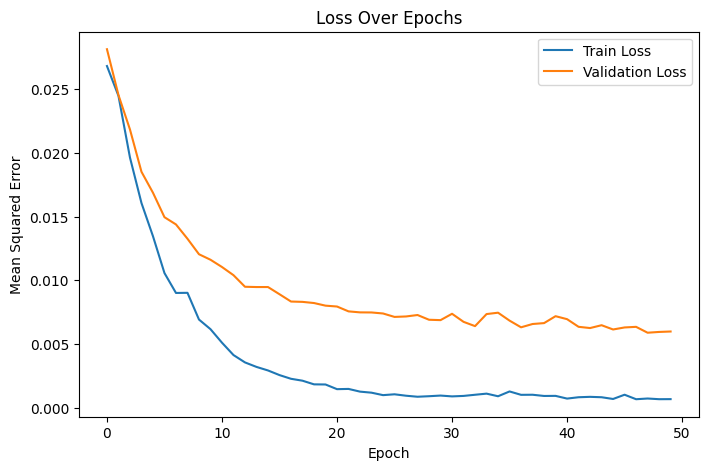

In [9]:
# Plotting the training history of the FCNN
plot_history(fcnn_history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\simon\AppData\Local\Temp\ipykernel_22128\1406451311.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


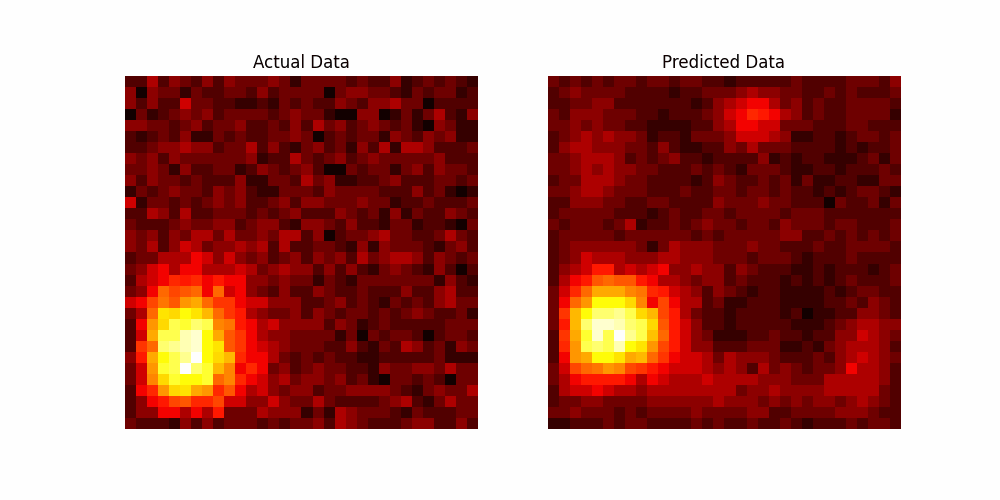

In [10]:
plot_comparison(fcnn_model, val_data, val_labels, save_path='plots/fcnn_comparison_plot.png')

In [ ]:
plot_comparison_as_gifs(fcnn_model, val_data, val_labels, save_dir='gifs/fcnn')

## Improvement 1: add inductive bias -> CNN

In [11]:
from tensorflow.keras.layers import Conv3D, InputLayer

def build_cnn(input_shape, output_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
    
        Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding="same", strides=(1, 1, 1)),
        Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', strides=(1, 1, 1)),
        
        Conv3D(1, kernel_size=(21, 1, 1), activation='linear', padding='valid', strides=(1, 1, 1))
    ])
    return model

In [12]:
cnn_model = build_cnn(input_shape, output_shape)
cnn_model.summary()
cnn_model.compile(optimizer='adam', loss='mse')
cnn_history = cnn_model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels))

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 60, 32, 32, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 60, 32, 32, 16) │         6,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 40, 32, 32, 1)  │           337 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,713 (30.13 KB)

 Trainable params: 7,713 (30.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - loss: 0.0333 - val_loss: 0.0125
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - loss: 0.0131 - val_loss: 0.0100
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - loss: 0.0084 - val_loss: 0.0073
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 716ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - loss: 0.0027 - val_loss:

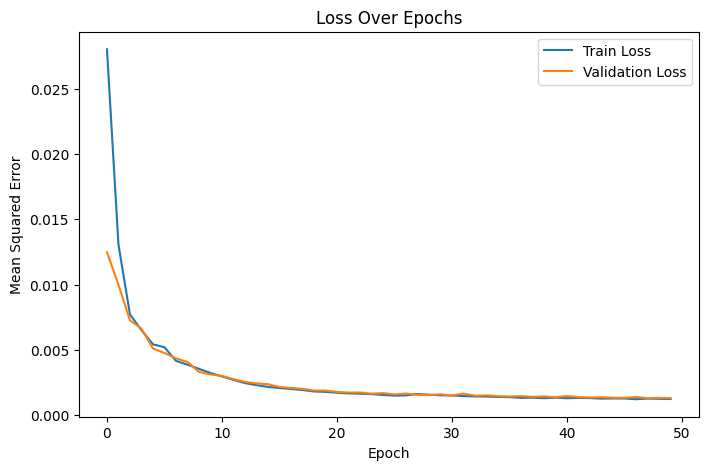

In [13]:
plot_history(cnn_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


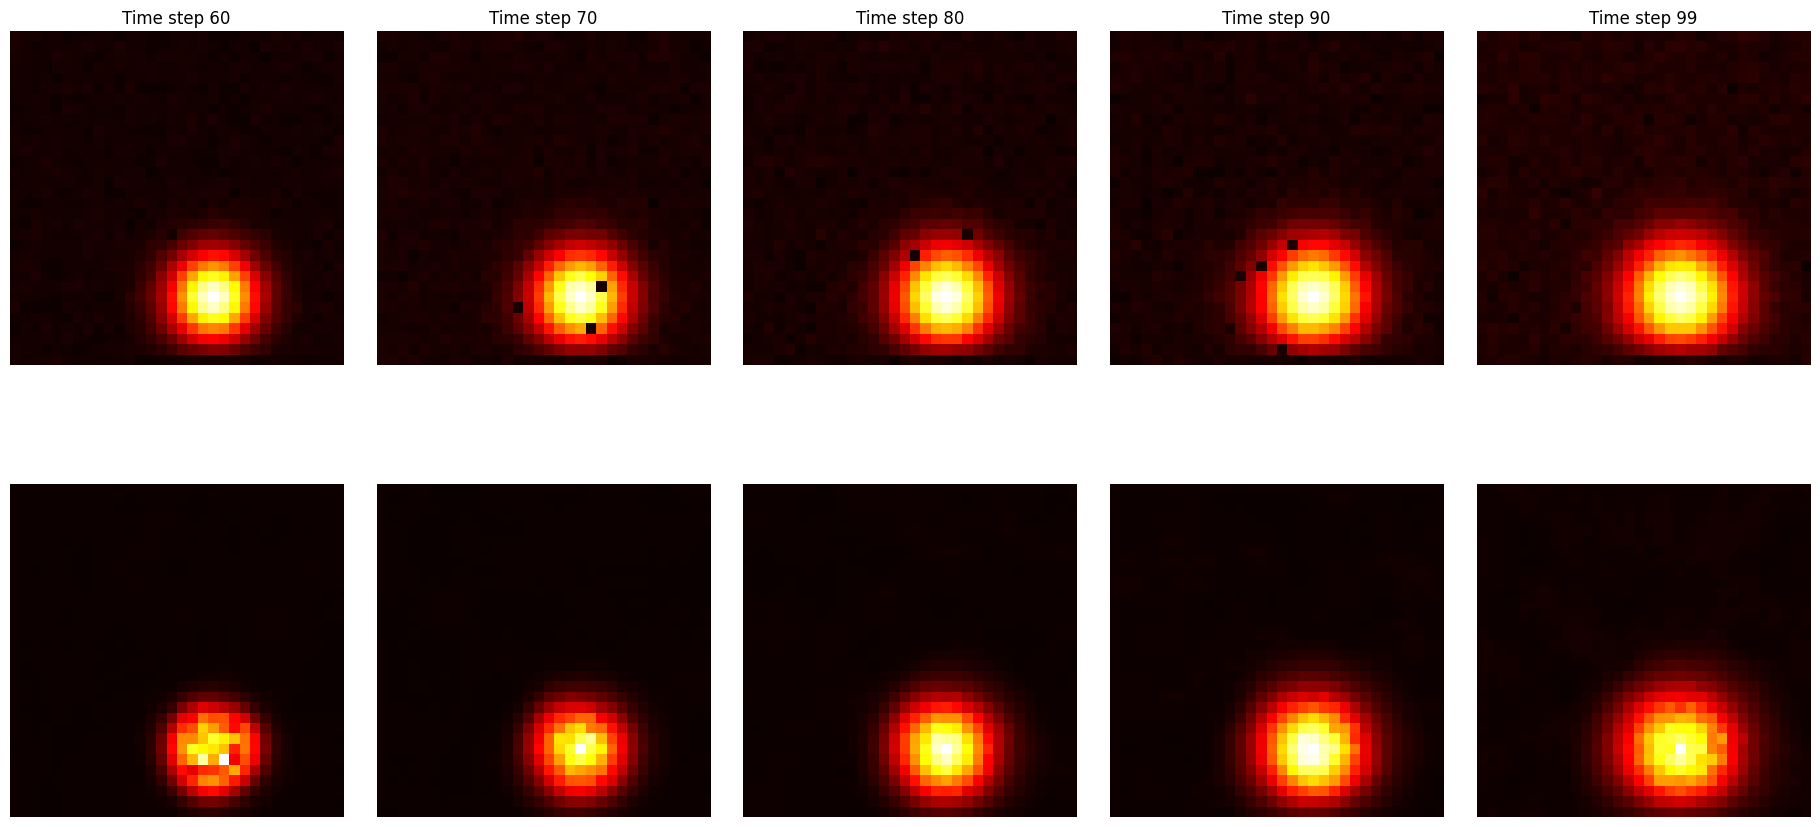

In [14]:
plot_comparison(cnn_model, val_data, val_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\simon\AppData\Local\Temp\ipykernel_22128\1406451311.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


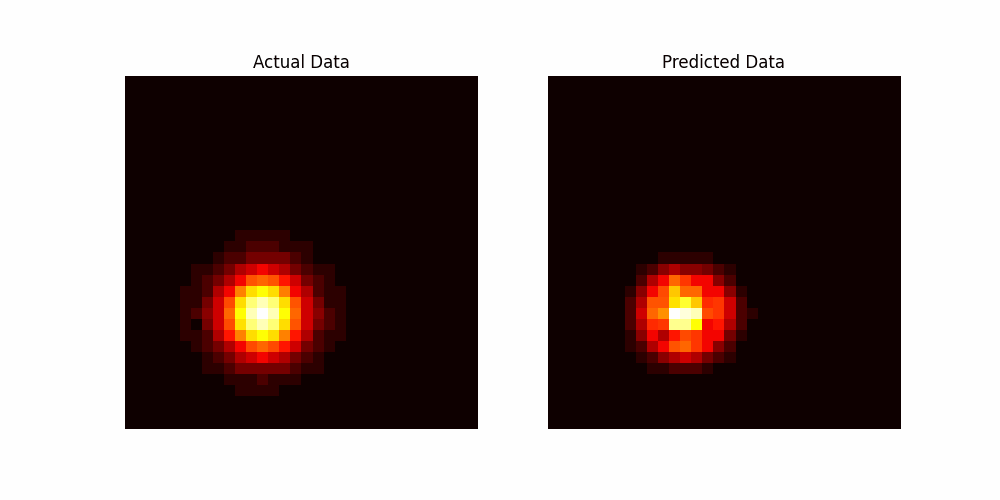

In [15]:
plot_comparison_as_gifs(cnn_model, val_data, val_labels)

## Improvement 2: add learning bias -> heat diffusion equation

The heat diffusion equation, commonly known as the heat equation, is expressed in the form:

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2 u
$$

Where 
- u is the temperature
- $\alpha$ is the diffusion coefficient
- $\nabla^2 u$ is the Lapacian

-> use finite difference approximation of Laplacian


In [16]:

def calculate_laplacian(y_pred):
    center = y_pred[:, :, 1:-1, 1:-1]
    top = y_pred[:, :, :-2, 1:-1]
    bot = y_pred[:, :, 2:, 1:-1]
    left = y_pred[:, :, 1:-1, :-2]
    right = y_pred[:, :, 1:-1, 2:]

    discrete_laplacian = top + bot + left + right - 4 * center
    return discrete_laplacian

def physics_informed_loss(w_l = 1., w_p = 1.):
    def loss(y_true, y_pred):

        # MSE Loss
        mse = tf.reduce_mean(tf.square(y_true - y_pred))

        # Physics-based Loss
        # Extract necessary slices from y_pred for central, north, south, east, and west points
        discrete_laplacian = calculate_laplacian(y_pred)
        
        # assuming a fixed alpha over a single time step
        physics_loss = tf.reduce_mean(tf.square(discrete_laplacian))
        
        # Combined Loss
        return w_l *  mse + w_p * physics_loss

    return loss


In [17]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # This assumes that your model has been modified to return mse and physics_loss as part of its output during training
        print("\nEpoch: {}, MSE: {:.4f}, Physics Loss: {:.4f}".format(epoch, logs['mse_metric'], logs['physics_loss_metric']))


def mse_metric(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def physics_loss_metric(y_true, y_pred):
    discrete_laplacian = calculate_laplacian(y_pred)
    return tf.reduce_mean(tf.square(discrete_laplacian))



In [18]:
picnn_model = build_cnn(input_shape, output_shape)

# Add these metrics to your model compile step
picnn_model.compile(optimizer='adam', loss=physics_informed_loss(w_l=1., w_p=1.), metrics=[mse_metric, physics_loss_metric])
picnn_history = picnn_model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels), callbacks=[LossAndErrorPrintingCallback()])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.0422 - mse_metric: 0.0216 - physics_loss_metric: 0.0206
Epoch: 0, MSE: 0.0173, Physics Loss: 0.0169
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - loss: 0.0402 - mse_metric: 0.0205 - physics_loss_metric: 0.0197 - val_loss: 0.0170 - val_mse_metric: 0.0075 - val_physics_loss_metric: 0.0094
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 0.0144 - mse_metric: 0.0064 - physics_loss_metric: 0.0079
Epoch: 1, MSE: 0.0059, Physics Loss: 0.0071
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - loss: 0.0140 - mse_metric: 0.0063 - physics_loss_metric: 0.0077 - val_loss: 0.0142 - val_mse_metric: 0.0071 - val_physics_loss_metric: 0.0071
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0123 - mse_metric: 0.0063 - physics_loss_metric: 0.0060
Epoch: 2, MSE: 0.0059, Physics Loss: 0.0055
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - loss: 0.0121 - mse_metric: 0.0062 - physics_loss_metric: 0.0058 - val_loss: 0.0101 - val_mse_metric: 0.0052 - val

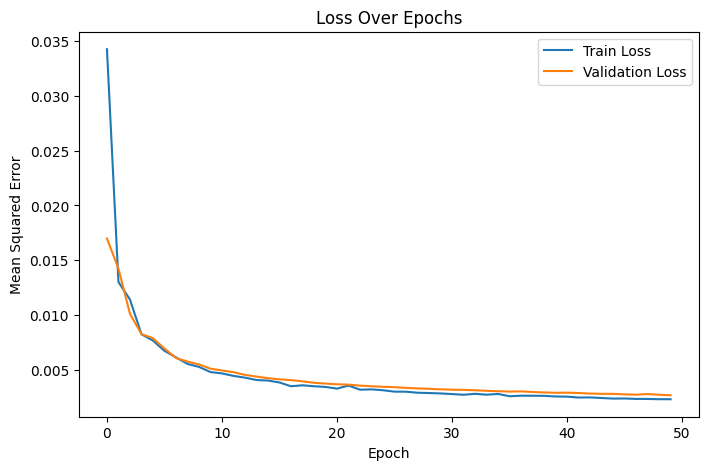

In [19]:
plot_history(picnn_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


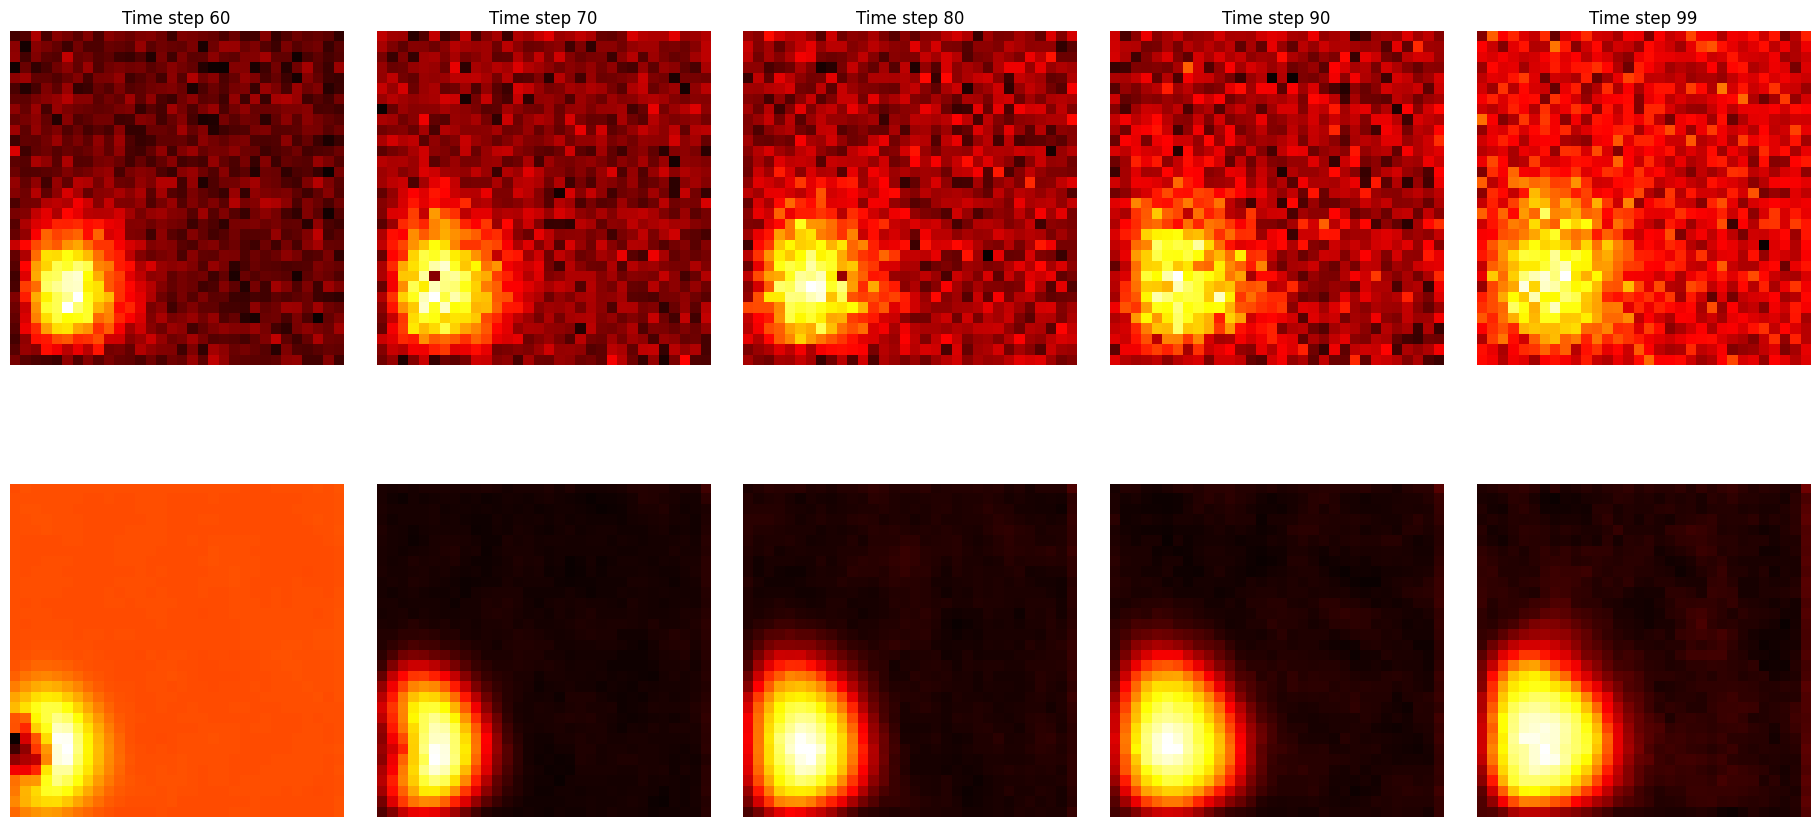

In [20]:
plot_comparison(picnn_model, val_data, val_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\simon\AppData\Local\Temp\ipykernel_22128\1406451311.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


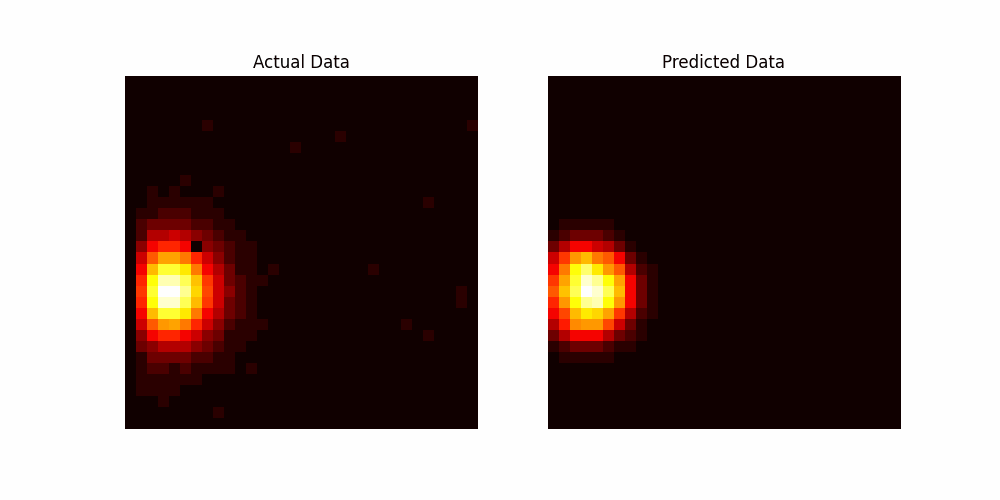

In [21]:
plot_comparison_as_gifs(picnn_model, val_data, val_labels)

## Improvement 3: Observational Bias -> preprocess data with heat diffusion equation

In [22]:
from scipy.signal import convolve2d
def diffusion_smoothing(data, alpha, iterations=1):
    # Define a diffusion kernel based on the alpha value
    kernel = np.array([[0, alpha, 0],
                       [alpha, 1 - 4 * alpha, alpha],
                       [0, alpha, 0]])
    

    smoothed_data = np.copy(data)
    for _ in range(iterations):
        for t in range(1, data.shape[1]-1):  # Avoid the first and last timestep to prevent boundary issues
            for sample in range(data.shape[0]):
                # Apply convolution to each 2D slice of each sample at each timestep
                for i in range(data.shape[4]): 
                    smoothed_data[sample, t, :, :, i] = convolve2d(smoothed_data[sample, t, :, :, i], kernel, mode='same', boundary='fill', fillvalue=0)
    
    return smoothed_data

In [23]:
cnn_model_2 = build_cnn(input_shape, output_shape)
cnn_model_2.compile(optimizer='adam', loss='mse')
train_data_smoothed = diffusion_smoothing(train_data, 0.1)
train_labels_smoothed = diffusion_smoothing(train_labels, 0.1)
cnn_history_2 = cnn_model_2.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 523ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - loss: 0.0018 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


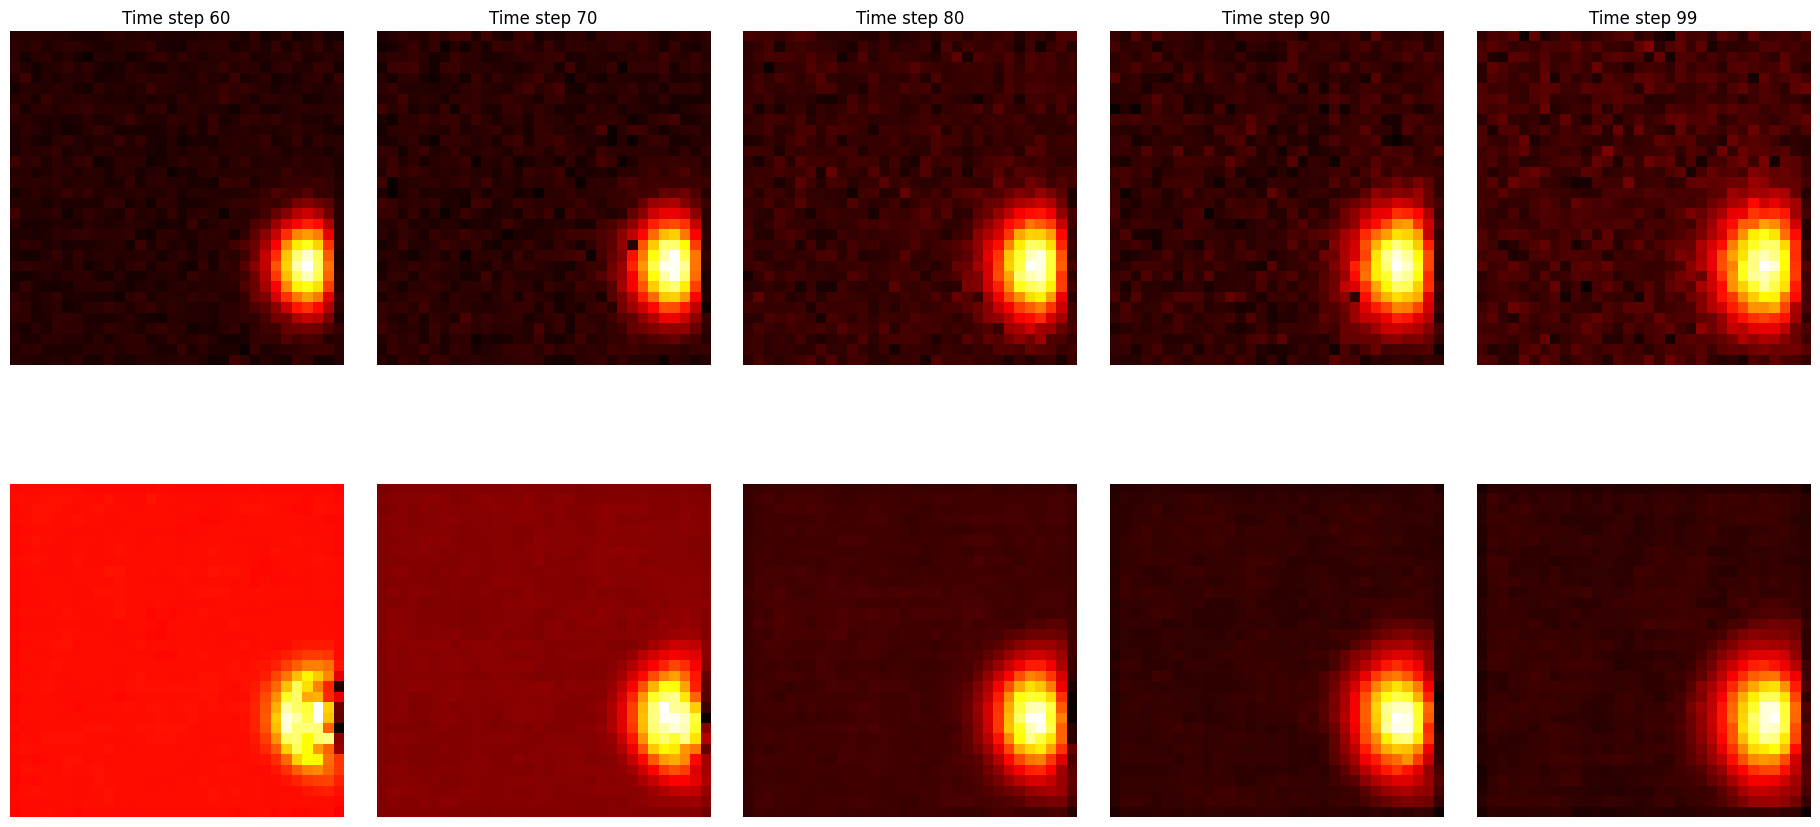

In [24]:
plot_comparison(cnn_model_2, val_data, val_labels)

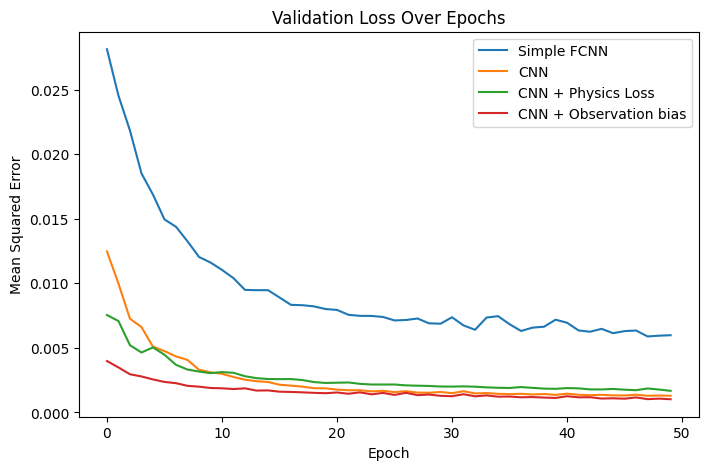

In [25]:
plot_model_comparison(fcnn_history, cnn_history, picnn_history, cnn_history_2)

## Considerations:
### Why use a CNN?
- Different possibilities to include time?
- how to design the CNN?

### What is our physics loss?
- What shoud we use?
- How do we choose the weights?
- When would the Laplacian be 0 in our example? Why does it still work?
- does adding physics informed loss work for the fully connected NN?

## Extra: FCNN with Learning Bias:

In [26]:
learning_fcnn_model = build_fcnn(input_shape, output_shape)

learning_fcnn_model.compile(optimizer='adam', loss=physics_informed_loss(w_l=1., w_p=0.5))
learing_fccn_history = learning_fcnn_model.fit(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0420 - val_loss: 0.0385
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0364 - val_loss: 0.0313
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0303 - val_loss: 0.0295
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0270 - val_loss: 0.0289
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0259 - val_loss: 0.0284
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0246 - val_loss: 0.0278
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0245 - val_loss: 0.0269
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0220 - val_loss: 0.0258
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0218 - val_loss: 0.0248
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0203 - val_loss: 0.0243
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0200 - val_loss: 0.0244
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0189 - val_loss: 0.024

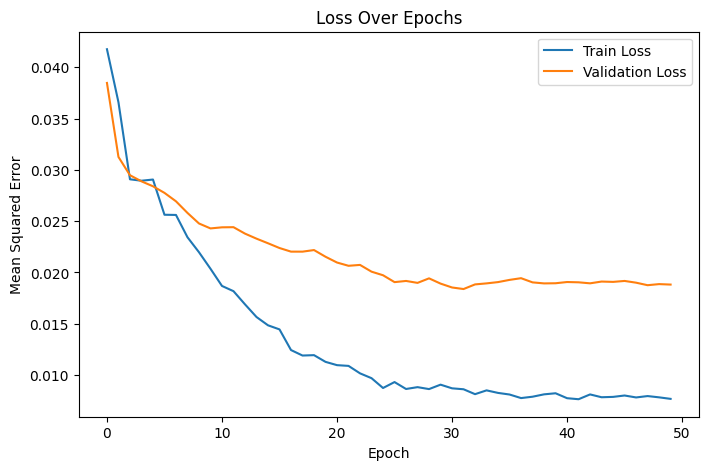

In [27]:
plot_history(learing_fccn_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


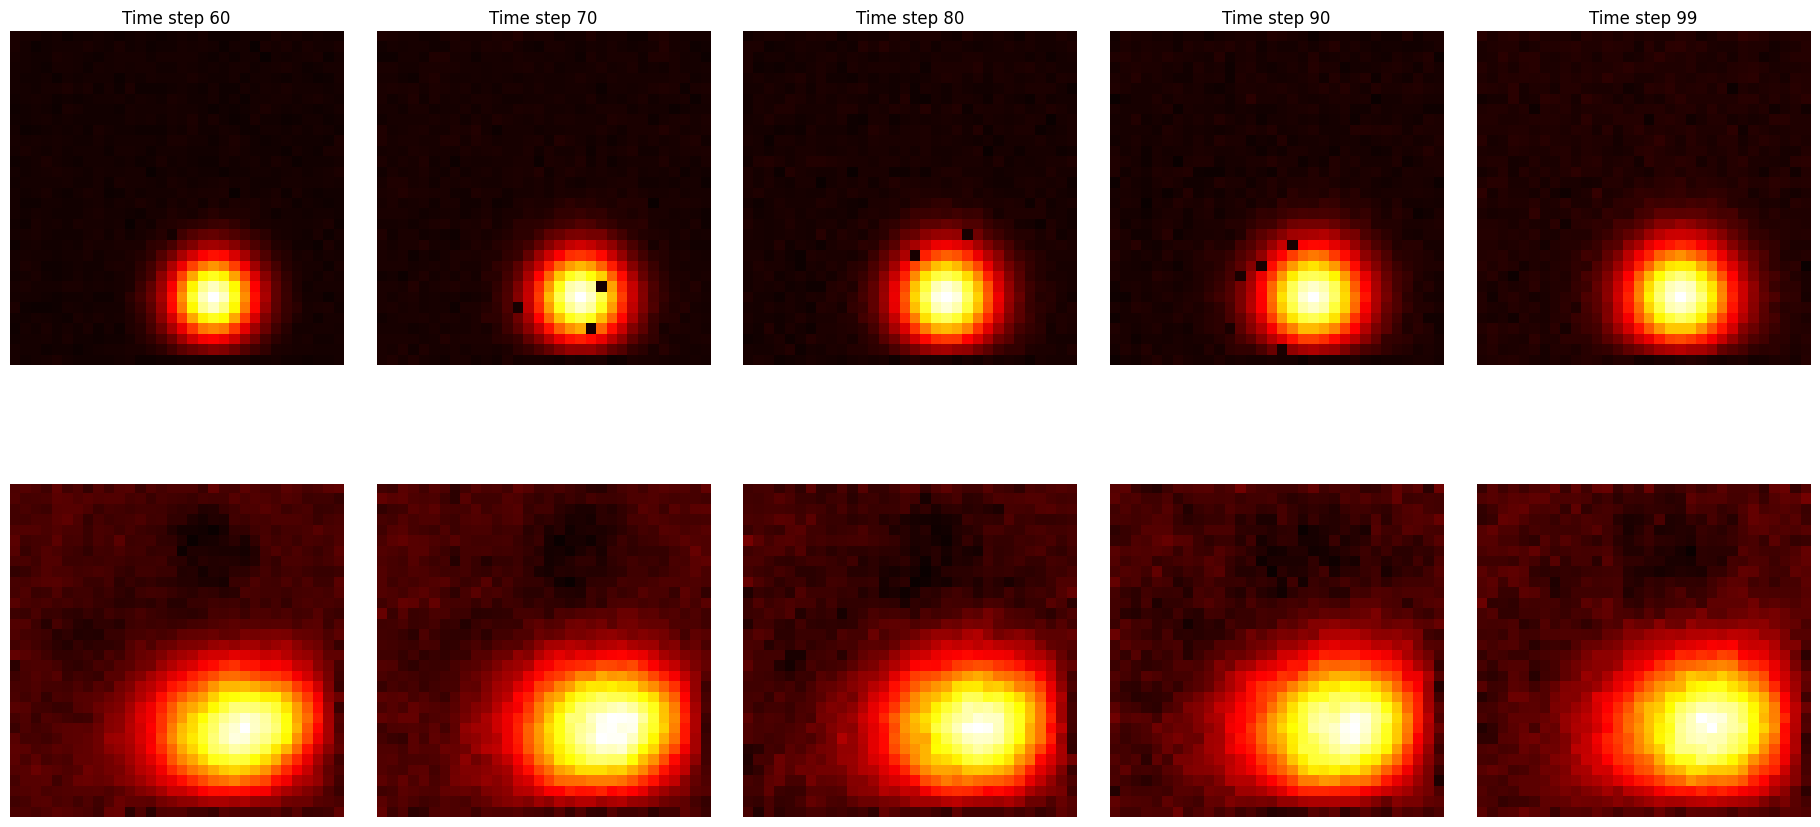

In [28]:
plot_comparison(learning_fcnn_model, val_data, val_labels)